# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [5]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


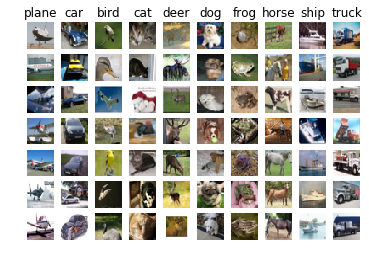

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [8]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


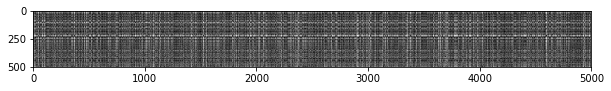

In [9]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$ *fill this in.*
- the bright rows indicate that this test case is far from all the training data, and seems doesn't belong to any given classes, so the distance is high with every kinds of species. 
- as for the columns, the black column indicate this training data is close to all the testing data, similarly, the white column indicates this training data is far from all the testing data.



In [11]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [12]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$
1. no change
2. no change
3. no change
4. no change
5. no change

$\color{blue}{\textit Your Explanation:}$
since L1 uses the subtracting distance between two objects, both the 5 ways will not change their distance order, although 3 and 4 will change the scale, but their order still remain the same.


In [15]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [20]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [21]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 46.473276 seconds
One loop version took 44.086806 seconds
No loop version took 0.373773 seconds


In [35]:
X_train[0:5]

array([[ 59.,  62.,  63., ..., 123.,  92.,  72.],
       [154., 177., 187., ..., 143., 133., 144.],
       [255., 255., 255., ...,  80.,  86.,  84.],
       [ 28.,  25.,  10., ...,  72.,  65.,  46.],
       [170., 180., 198., ...,  73.,  77.,  80.]])

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [53]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
'''  
split_index = X_train.shape[0] // num_folds
for i in range(0, num_folds):
    X_train_folds.append( X_train[split_index[i]], : )
    y_train_folds.append( y_train[split_index[i]], : )
'''  
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in k_choices:
    for j_fold in range(0, num_folds):
        print('i is', i, 'j_fold is:', j_fold) #'X_train_folds is:', X_train_folds
        X_test_split = X_train_folds[j_fold]
        
        print('X_test_split is',X_test_split, 'shape is', X_test_split.shape)
        #X_train_remain = X_train_folds.remove(X_train_folds[j])
        #X_train_split = np.vstack((X_train_remain))
        X_train_split = X_train_folds[0:j_fold] + X_train_folds[j_fold+1:]
        X_train_split = np.vstack((X_train_split))
        print('X_train_split shape:', X_train_split.shape)
        
        y_test_split = y_train_folds[j_fold]
        #y_train_remain = y_train_folds.remove(y_test_split)
        #y_train_split = np.vstack((y_train_remain))
        print('y_test_split shape is', y_test_split.shape)
        y_train_split = y_train_folds[0:j_fold] + y_train_folds[j_fold+1:]
        y_train_split = np.hstack((y_train_split))
        print('y_train_split shape is', y_train_split.shape)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train_split, y_train_split)
        
        dists = classifier.compute_distances_no_loops(X_test_split)
        print('dists is',dists, 'shape is', dists.shape)
        y_test_pred = classifier.predict_labels(dists, k=i)
        num_correct = np.sum(y_test_pred == y_test_split)
        accuracy = float(num_correct) / len(y_test_split)
        
        if i in k_to_accuracies.keys():
            k_to_accuracies[i].append(accuracy)
        else:
            k_to_accuracies[i] = [accuracy]       
        
'''    
res.remove(res[0])
np.vstack((res))

classifier.train(X_train, y_train)

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

dists = classifier.compute_distances_no_loops(X_test)
y_test_pred = classifier.predict_labels(dists, k=i)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
    
''' 

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

i is 1 j_fold is: 0
X_test_split is [[ 59.  62.  63. ... 123.  92.  72.]
 [154. 177. 187. ... 143. 133. 144.]
 [255. 255. 255. ...  80.  86.  84.]
 ...
 [145. 148. 157. ... 126. 160.  91.]
 [146. 146. 146. ... 238. 238. 238.]
 [203. 206. 208. ... 132. 131. 126.]] shape is (1000, 3072)
X_train_split shape: (4000, 3072)
y_test_split shape is (1000,)
y_train_split shape is (4000,)
dists is [[5429.76030779 4734.88574308 4855.95037042 ... 4006.57072819
  4212.60180886 4061.94017681]
 [4822.09062544 5149.88213457 5685.16499321 ... 4140.58619038
  4153.84604915 5665.2589526 ]
 [4651.24542461 6430.06049738 6278.95094741 ... 4025.00509316
  4940.09807595 7017.85658161]
 ...
 [5175.0191304  5798.92308968 4260.14365955 ... 3935.06022826
  4646.03917332 4924.37630569]
 [5214.36103468 6436.73123565 6397.96717716 ... 5425.63498588
  4838.48282006 8172.90915158]
 [5352.33014677 5410.92450511 4510.60672194 ... 4066.22429288
  4739.01793624 4478.77561394]] shape is (1000, 4000)
i is 1 j_fold is: 1
X_te

i is 3 j_fold is: 4
X_test_split is [[ 86. 138. 179. ...  75. 123. 163.]
 [158. 156. 178. ...  61.  65.  66.]
 [185. 190. 180. ... 144. 113.  74.]
 ...
 [167. 163. 145. ...  42.  78.  84.]
 [154. 152. 125. ... 194. 247. 114.]
 [ 45.  32.  21. ... 156. 142. 100.]] shape is (1000, 3072)
X_train_split shape: (4000, 3072)
y_test_split shape is (1000,)
y_train_split shape is (4000,)
dists is [[4639.17147775 4150.04204798 6078.16822735 ... 4574.69244868
  6173.21796148 6273.58358516]
 [5316.76142026 5007.02895937 6562.17776352 ... 5625.18381922
  6686.1434325  6551.39687395]
 [4323.06072129 3837.79689405 5308.50346143 ... 4282.69809816
  5314.82567917 5683.58487224]
 ...
 [4006.57072819 4140.58619038 4025.00509316 ... 3281.6261213
  4104.65138593 5276.67944829]
 [4212.60180886 4153.84604915 4940.09807595 ... 2817.10933405
  4740.08565323 5764.01899719]
 [4061.94017681 5665.2589526  7017.85658161 ... 5335.07947457
  6871.89449861 3526.99007654]] shape is (1000, 4000)
i is 5 j_fold is: 0
X_tes

i is 8 j_fold is: 3
X_test_split is [[254. 254. 254. ... 217. 215. 213.]
 [175. 247. 159. ... 110. 110. 136.]
 [ 91.  67.  69. ...   5.   2.   3.]
 ...
 [164. 150. 127. ... 161. 138. 103.]
 [228. 236. 240. ...  92. 105. 113.]
 [ 90. 109.  89. ...  83. 153.  57.]] shape is (1000, 3072)
X_train_split shape: (4000, 3072)
y_test_split shape is (1000,)
y_train_split shape is (4000,)
dists is [[4796.67009497 5253.95060883 5127.9047378  ... 4046.27075219
  4335.44346059 5684.19809648]
 [5414.64283217 4941.42388386 4501.1478536  ... 4207.54584051
  3352.67490222 6193.3749281 ]
 [4055.82445379 5330.30308707 6436.92216824 ... 4551.43307102
  5185.51771764 4040.37770512]
 ...
 [4067.63948747 4476.91969997 4541.6915351  ... 3281.6261213
  2817.10933405 5335.07947457]
 [6408.65633343 5894.00296912 3041.87984641 ... 4104.65138593
  4740.08565323 6871.89449861]
 [4421.83683552 5959.92718076 6807.87867107 ... 5276.67944829
  5764.01899719 3526.99007654]] shape is (1000, 4000)
i is 8 j_fold is: 4
X_tes

i is 12 j_fold is: 2
X_test_split is [[255. 255. 247. ...  53.  52.  45.]
 [119. 103.  92. ...  95. 113. 126.]
 [255. 255. 255. ... 159. 160. 164.]
 ...
 [ 29.  32.  32. ... 212. 215. 207.]
 [171. 151. 119. ... 166. 147. 117.]
 [213. 219. 244. ...  52.  54.  44.]] shape is (1000, 3072)
X_train_split shape: (4000, 3072)
y_test_split shape is (1000,)
y_train_split shape is (4000,)
dists is [[4824.79502155 4740.09999895 3377.00103642 ... 3142.35930473
  3908.81247951 6001.71617123]
 [4295.42652131 4378.72013264 6379.49872639 ... 4462.80427534
  5194.81578114 4284.79976195]
 [4679.54014835 4546.64612654 5358.28284061 ... 4123.63298561
  4111.06385258 5172.24535381]
 ...
 [4324.74242008 5261.02119365 6747.44677637 ... 5194.47398684
  4602.22522265 3880.36634868]
 [4028.16012591 4529.3303037  4586.5340945  ... 3183.46619269
  3045.4431533  5080.84225301]
 [6268.23220693 4781.72081996 4635.24821342 ... 5131.90568892
  4552.16772538 7620.88505359]] shape is (1000, 4000)
i is 12 j_fold is: 3
X_

i is 20 j_fold is: 1
X_test_split is [[242. 243. 250. ... 105. 123. 135.]
 [ 56.  50.  28. ... 131. 112.  86.]
 [100.  86.  89. ...  44.  49.  48.]
 ...
 [ 41.  47.  35. ... 161. 149.  89.]
 [ 66. 101. 131. ... 171. 176. 186.]
 [124. 190. 225. ... 138. 145. 110.]] shape is (1000, 3072)
X_train_split shape: (4000, 3072)
y_test_split shape is (1000,)
y_train_split shape is (4000,)
dists is [[5429.76030779 4822.09062544 4651.24542461 ... 4205.26574666
  4225.6697694  6292.67613977]
 [4734.88574308 5149.88213457 6430.06049738 ... 5415.06934397
  3750.67500592 5886.7348335 ]
 [4855.95037042 5685.16499321 6278.95094741 ... 4875.60283452
  5398.38105361 5424.50901004]
 ...
 [3879.97938139 5433.55436156 6574.74630689 ... 4944.8972689
  5395.56113857 3397.6368258 ]
 [3972.3360885  4707.26512956 7019.4650081  ... 5090.1167963
  4343.71108616 4460.71787944]
 [4902.19155073 4135.42827286 3631.29962961 ... 3671.84299773
  3706.13923106 5939.80471059]] shape is (1000, 4000)
i is 20 j_fold is: 2
X_te

i is 100 j_fold is: 0
X_test_split is [[ 59.  62.  63. ... 123.  92.  72.]
 [154. 177. 187. ... 143. 133. 144.]
 [255. 255. 255. ...  80.  86.  84.]
 ...
 [145. 148. 157. ... 126. 160.  91.]
 [146. 146. 146. ... 238. 238. 238.]
 [203. 206. 208. ... 132. 131. 126.]] shape is (1000, 3072)
X_train_split shape: (4000, 3072)
y_test_split shape is (1000,)
y_train_split shape is (4000,)
dists is [[5429.76030779 4734.88574308 4855.95037042 ... 4006.57072819
  4212.60180886 4061.94017681]
 [4822.09062544 5149.88213457 5685.16499321 ... 4140.58619038
  4153.84604915 5665.2589526 ]
 [4651.24542461 6430.06049738 6278.95094741 ... 4025.00509316
  4940.09807595 7017.85658161]
 ...
 [5175.0191304  5798.92308968 4260.14365955 ... 3935.06022826
  4646.03917332 4924.37630569]
 [5214.36103468 6436.73123565 6397.96717716 ... 5425.63498588
  4838.48282006 8172.90915158]
 [5352.33014677 5410.92450511 4510.60672194 ... 4066.22429288
  4739.01793624 4478.77561394]] shape is (1000, 4000)
i is 100 j_fold is: 1


In [54]:
#X_train.shape[0] // 5

1000

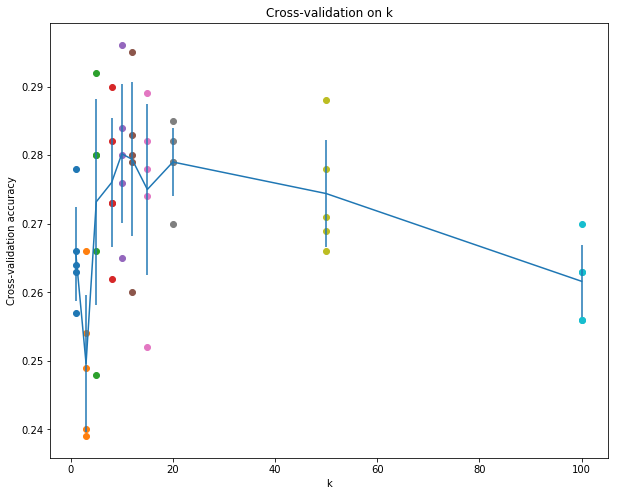

In [55]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [60]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$
4. 

$\color{blue}{\textit Your Explanation:}$
1. the boundary is not linear
2. training error has no relation with k
3. through the figure we have draw above, we can see that the accuracy of k=1 can be higher than k=5 in some cases, so it depends.
4. the training set is larger and we need more time to calculate their distances.
